# Objectives

* Compare mathematical libraries in the context of neuroimaging pipelines
* Should one particular library be recommended?

# Methods

* Installed [musl libc](https://www.musl-libc.org), [openlibm](https://github.com/JuliaMath/openlibm) version 0.7.0 and 0.7.5, [Intel oneAPI Base Toolkit](https://software.intel.com/content/www/us/en/develop/tools/oneapi/base-toolkit/download.html#gs.zgfmhs), and [GNU MPFR](https://www.mpfr.org) in a Ubuntu 20 (glibc 2.31) container ([Dockerfile](https://github.com/glatard/manymaths/blob/main/Dockerfile)).
* Preloaded [math wrappers](https://github.com/glatard/manymaths/blob/main/wrap/wrap.c) of each library such that applications can use them transparently (no recompilation). MPFR was enabled using a different but similar [wrapper](https://github.com/glatard/manymaths/blob/main/wrap/wrap-mpfr.c).
* Installed [HCP minimal pre-processing pipelines](https://github.com/Washington-University/HCPpipelines) in this environment ([Dockerfile](https://github.com/glatard/manymaths/blob/main/Dockerfile.pfs)).
* Repeated the processing of 1 subject with each library.

# Results

Results are compared on the main pipeline output: spatial normalization of T1 image in MNI space. 

In [1]:
import os
data_dir = os.path.join(os.getenv('HOME'), 'data', 'manymaths')
lib_versions = ['glibc-v2.31', 'musl-v1.1.24-1', 'openlibm-v0.7.0', 'openlibm-v0.7.5', 'intel-v2021.2.0', 'mpfr']
subjects = ['101309']
files = [ os.path.join(data_dir, lib_version, subject, 'MNINonLinear', 'T1w.nii.gz')
                    for lib_version in lib_versions for subject in subjects ]

In [2]:
import hashlib
hashes = [ hashlib.md5(open(filename,'rb').read()).hexdigest() for filename in files]
hashes

['14e8cf608284cd6fcbe22fdc578e6090',
 'ade2e5455d8c601774f014eb1fb17f4d',
 '855bbc3de4332cfb7ca254a08ab380a4',
 '855bbc3de4332cfb7ca254a08ab380a4',
 'e7314b3703cde99f7cb7107837889c10',
 'e891000774953150b4a5b141f0eb6141']

All the results are different, except for the results obtained with the two openlibm versions.

Let's exclude the oldest openlibm version:

In [3]:
lib_versions = [ lv for lv in lib_versions if lv != 'openlibm-v0.7.0' ]
files = [ os.path.join(data_dir, lib_version, subject, 'MNINonLinear', 'T1w.nii.gz')
                    for lib_version in lib_versions for subject in subjects ]

## Comparison to MPFR

Which library is closest to MPFR?

Let's mask the images to discard the background:

In [4]:
import nibabel as nib

# Load mask
mask_img = os.path.join(data_dir, "MNI152_T1_0.7mm_fg_mask.nii.gz")
mask_img = nib.load(mask_img)
mask_img_dat = mask_img.get_fdata()
mask_locs = mask_img_dat > 0

In [5]:
import numpy as np

# Load (masked) image data
T1_flat = np.array([nib.load(file).get_fdata()[mask_locs].flatten() for file in files])

In [6]:
# T1s is an array of shape (n, m) where n is the number of images to cluster 
# and m is the number of foreground voxels per image
np.shape(T1_flat)

(5, 9910560)

We will use the RMSE as image distance:

In [7]:
def rmse(data1, data2):
    return np.sqrt(np.mean((data1-data2)**2, dtype=np.float64), dtype=np.float64)

Distance between MPFR and the other libraries:

In [8]:
mpfr_ind = lib_versions.index("mpfr")
rmses = [ (lib_versions[i], round(rmse(T1_flat[i], T1_flat[mpfr_ind]),2))
           for i in range(len(lib_versions)) if i!=mpfr_ind ]
sorted(rmses, key=lambda x: x[1])

[('intel-v2021.2.0', 20.65),
 ('openlibm-v0.7.5', 21.88),
 ('glibc-v2.31', 22.67),
 ('musl-v1.1.24-1', 27.21)]

Intel's results are the closest to MPFR's, followed by openlibm, glibc and finally musl.

## Clustering

How similar are results obtained with different libraries?

Let's use scipy's hierarchical clustering:

In [9]:
import scipy
import scipy.spatial

# Compute dense 1D distance matrix
distance_mat = scipy.spatial.distance.pdist(T1_flat, metric=rmse)
distance_mat

array([19.68441796, 18.7087812 , 15.75948343, 22.67146974, 22.50715437,
       18.43772268, 27.20787327, 20.94443229, 21.87535609, 20.64520372])

In [10]:
np.mean(distance_mat)

20.84418947484328

The mean RMSE between results obtained in different libraries is consistent with the one previously observed between different versions of glibc.

Let's now cluster the results using [hierarchical clustering]((https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html):

In [11]:
# Hierarchical clustering
from scipy.cluster import hierarchy
Z = hierarchy.linkage(distance_mat, 'average')

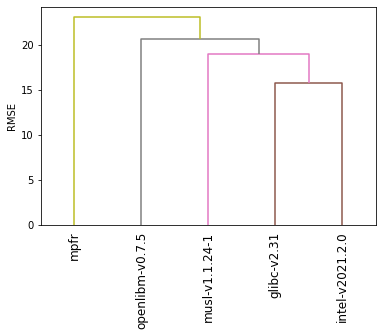

In [12]:
# Plot dendrogram
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors

fig, ax = plt.subplots(1)
ax.set_ylabel("RMSE")
colors = list(mcolors.TABLEAU_COLORS)
hierarchy.dendrogram(Z, labels=lib_versions, leaf_rotation=90, link_color_func=lambda k: colors[k], ax=ax)
plt.show()

**Notes**

* MPFR stands out from the other libraries
* glibc and intel are the most similar results

## Visualization

Are the differences localized spatially?

In [ ]:
import matplotlib
import nilearn.plotting as nilp
import matplotlib.cm as cm
from matplotlib import pyplot as plt
import matplotlib.colors as colors

matplotlib.rcParams.update({'font.size': 20})

T1_data = [nib.load(os.path.join(data_dir, lib_version, subject, 'MNINonLinear', 'T1w.nii.gz'))
                    for lib_version in lib_versions for subject in subjects ]


fig, axs = plt.subplots(len(T1_data)-1, len(T1_data)-1, figsize=(40,40))

for i in range(len(T1_data)-1):
    for j in range(i+1, len(T1_data)):
        im1 = T1_data[i]
        data1 = im1.get_fdata()*mask_img_dat
        im2 = T1_data[j]
        data2 = im2.get_fdata()*mask_img_dat
        data = (data1-data2)/(data1)
        rel_diff = nib.Nifti1Image(data, im1.affine)
        axs[i, j-1].set_title(lib_versions[i]+" VS "+lib_versions[j])
        im = nilp.plot_img(rel_diff, cmap=cm.seismic, norm=colors.SymLogNorm(vmin=-1, vmax=1,
                                                                        linthresh=0.03, linscale=0.03,
                                                                        base=10),
                      cut_coords=(0,),
                      colorbar=True, draw_cross=False, display_mode='z', vmin=-1, vmax=1,
                      axes=axs[i, j-1])

plt.show()

/home/glatard/code/imcomp/venv/lib/python3.8/site-packages/nilearn/datasets/__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "
<ipython-input-13-e6f57bd05ab4>:21: RuntimeWarning: invalid value encountered in true_divide
  data = (data1-data2)/(data1)
/home/glatard/code/imcomp/venv/lib/python3.8/site-packages/nilearn/_utils/niimg.py:61: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(
/home/glatard/code/imcomp/venv/lib/python3.8/site-packages/nilearn/plotting/displays.py:101: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  im = getattr(ax, type)(data_2d.copy(),


**Notes**

MPFR results are very different from the other ones indeed.


A spatial dependency of numerical differences is observed in the brain. For instance, openlibm differs from the other libraries in the occipital lobe, and intel is singular in the frontal lobe. 

While it would be surprising that the spatial localization of such differences be consisent across subjects, it suggests that numerical libraries might be converging to different local minima during non linear registration.

# Future work

## Next
* Process more subjects

## Later
* Measure numerical precision of the pipeline for each library using MCA
* Measure imaging quality of the pipeline for each library by visual QC
* Measure "biological" performance of the pipeline for each library using age regression